<a href="https://colab.research.google.com/github/joeyee614/tradingstrategies/blob/main/Trading_Strategies_(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trading Strategies(b)

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings
import io

In [ ]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%config InlineBackend.figure_format = 'svg'

Linear OLS Regression

The Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tr_eikon_eod_data.csv to tr_eikon_eod_data.csv


In [ ]:
raw = pd.read_csv('tr_eikon_eod_data.csv')

In [ ]:
raw.columns

Index(['Date', 'AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX',
       '.VIX', 'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [ ]:
symbol = 'EUR='

In [ ]:
data = pd.DataFrame(raw[symbol])

In [ ]:
data['returns'] = np.log(data / data.shift(1))

In [ ]:
data.dropna(inplace = True)

In [ ]:
data['direction'] = np.sign(data['returns']).astype(int)

In [ ]:
data.head()

,EUR=,returns,direction
1,1.4411,0.006125,1
2,1.4368,-0.002988,-1
3,1.4412,0.003058,1
4,1.4318,-0.006544,-1
5,1.4412,0.006544,1


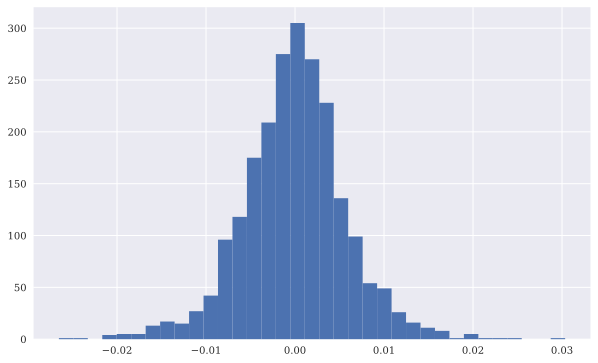

In [ ]:
data['returns'].hist(bins=35, figsize=(10, 6));

In [ ]:
lags = 2

In [ ]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data["returns"].shift(lag)
        cols.append(col)


In [ ]:
create_lags(data)

In [ ]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
1,1.4411,0.006125,1,NaN,NaN
2,1.4368,-0.002988,-1,0.006125,NaN
3,1.4412,0.003058,1,-0.002988,0.006125
4,1.4318,-0.006544,-1,0.003058,-0.002988
5,1.4412,0.006544,1,-0.006544,0.003058


In [ ]:
data.dropna(inplace=True)

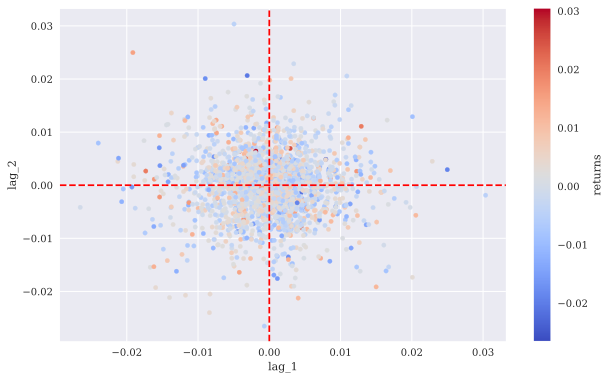

In [ ]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns',
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [ ]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [ ]:
data[['pos_ols_1','pos_ols_2']].head()

,pos_ols_1,pos_ols_2
3,-0.000002,-0.000663
4,-0.000164,0.001545
5,0.000030,0.032971
6,-0.000245,-0.004227
7,-0.000154,-0.061068


In [ ]:
data[['pos_ols_1','pos_ols_2']] = np.where(
             data[['pos_ols_1','pos_ols_2']] > 0, 1, -1)

In [ ]:
data['pos_ols_1'].value_counts()

-1    1863
 1     350
Name: pos_ols_1, dtype: int64

In [ ]:
data['pos_ols_2'].value_counts()

 1    1310
-1     903
Name: pos_ols_2, dtype: int64

In [ ]:
(data['pos_ols_1'].diff() != 0).sum()

653

In [ ]:
(data['pos_ols_2'].diff() != 0).sum()

766

In [ ]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [ ]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [ ]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.813126
strat_ols_1    0.987177
strat_ols_2    1.287336
dtype: float64

In [ ]:
(data['direction'] == data['pos_ols_1']).value_counts()

False    1132
True     1081
dtype: int64

In [ ]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     1145
False    1068
dtype: int64

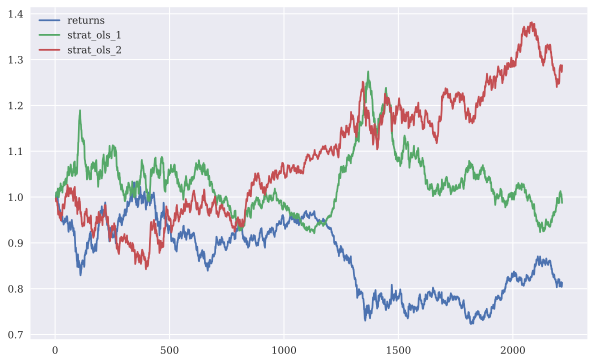

In [ ]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(n_clusters=2, random_state=0)

In [ ]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [ ]:
data['pos_clus'] = model.predict(data[cols])

In [ ]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [ ]:
data['pos_clus'].values

array([-1,  1, -1, ..., -1, -1,  1])

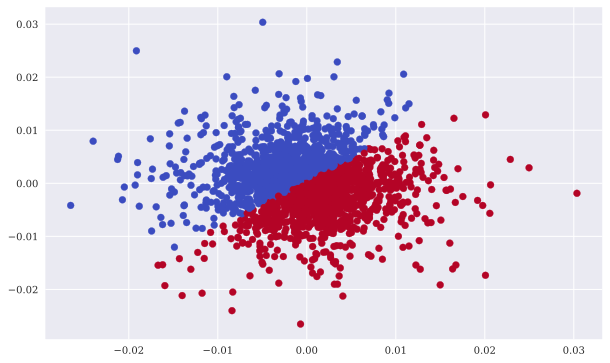

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');

Classification Algorithms

In [ ]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
C = 1

In [ ]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [ ]:
def fit_models(data):
  mfit = {model: models[model].fit(data[cols.bin], data['direction'])
          for model in models.keys()}

In [ ]:
fit_models(data)

AttributeError: ignored

Frequency Approach

In [ ]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin=[]
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [ ]:
create_bins(data)

In [ ]:
data[cols_bin +['direction']].head()

,lag_1_bin,lag_2_bin,direction
3,0,1,1
4,1,0,-1
5,0,1,1
6,1,0,1
7,1,1,-1


In [ ]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           237
                       0             4
                       1           276
           1          -1           280
                       0             1
                       1           295
1          0          -1           287
                       0             1
                       1           288
           1          -1           288
                       0             5
                       1           251
dtype: int64

DNN with scikit-learn

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                      hidden_layer_sizes=2 *[250], random_state=1)

In [ ]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 5.24 s, sys: 4.25 s, total: 9.49 s
Wall time: 5.81 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [ ]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [ ]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [ ]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp)

,returns,strat_dnn_sk
3,1.003062,1.003062
4,0.996520,0.996520
5,1.003062,1.003062
6,1.010092,1.010092
7,1.008769,1.011416
...,...,...
2211,0.814449,1.008430
2212,0.810482,1.013366
2213,0.804009,1.005273
2214,0.805053,1.006578


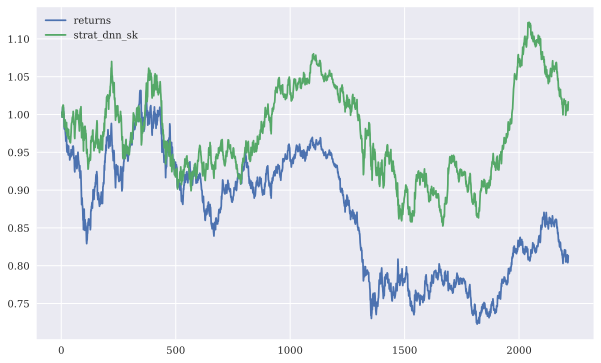

In [ ]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize =(10,6));

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [ ]:
train = train.copy().sort_index()

In [ ]:
test = test.copy().sort_index()

In [ ]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                      hidden_layer_sizes=3 * [500], random_state=1)

In [ ]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 16.2 s, sys: 8.68 s, total: 24.9 s
Wall time: 14.9 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [ ]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [ ]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [ ]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.644018
strat_dnn_sk    0.795527
dtype: float64

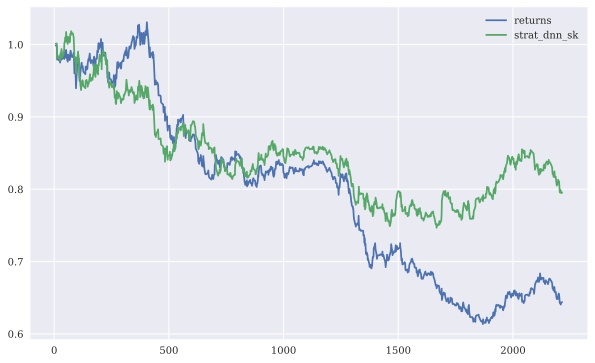

In [ ]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

DNN with Keras & TensorFlow Backend

In [ ]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation ='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [ ]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [ ]:
model = create_model()

In [ ]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: user 8.65 s, sys: 289 ms, total: 8.94 s
Wall time: 11.9 s


In [ ]:
model.evaluate(data_[cols], data['direction_'])

70/70 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5404


[0.687004029750824, 0.5404428243637085]

In [ ]:
pred = np.where(model.predict(data_[cols])> 0.5, 1, 0)
pred[:10].flatten()

70/70 [==============================] - 0s 6ms/step


array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
data['pos_dnn_ke'] = np.where(pred >0, 1, -1)

In [ ]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [ ]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.813126
strat_dnn_ke    1.948574
dtype: float64

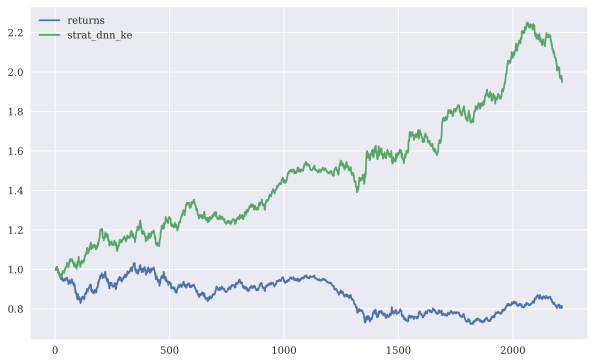

In [ ]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
mu, std